# Load in Cleaned Dataset: `demo_killings_df`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from tqdm.notebook import tqdm

from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
with open('Data/demo_killings_df.pkl','rb') as read_file:
    demo_killings_df = pickle.load(read_file)

In [3]:
demo_killings_df

,merge_key,id,name,date,year,month,day_of_week,region,manner_of_death,armed,...,body_camera,city_type,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
0,Shelton_WA,3,Tim Elliot,2015-01-02,2015,January,Friday,West Coast,shot,gun,...,False,City,28.6,80.1,78.9,0.8,3.7,1.1,19.2,37072.0
1,Aloha_OR,4,Lewis Lee Lembke,2015-01-02,2015,January,Friday,West Coast,shot,gun,...,False,Cdp,14.9,88.1,70.9,2.6,1.0,8.9,21.1,65765.0
2,Wichita_KS,5,John Paul Quintero,2015-01-03,2015,January,Saturday,Central,shot and Tasered,unarmed,...,False,City,17.3,87.5,71.9,11.5,1.2,4.8,15.3,45947.0
3,San_Francisco_CA,8,Matthew Hoffman,2015-01-04,2015,January,Sunday,West Coast,shot,non-lethal object,...,False,City,13.2,87.0,48.5,6.1,0.5,33.3,15.1,81294.0
4,Evans_CO,9,Michael Rodriguez,2015-01-04,2015,January,Sunday,Mountain,shot,gun,...,False,City,16.6,76.3,76.5,0.9,1.2,0.9,43.1,47791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,Chowchilla_CA,2812,Alejandro Alvarado,2017-07-27,2017,July,Thursday,West Coast,shot,sharp object,...,False,City,32.1,68.3,61.6,12.6,2.0,2.1,37.8,34559.0
2346,Kansas_City_MO,2822,Rodney E. Jacobs,2017-07-28,2017,July,Friday,Midwest,shot,gun,...,False,City,19.0,88.4,59.2,29.9,0.5,2.5,10.0,45821.0
2347,Albuquerque_NM,2813,TK TK,2017-07-28,2017,July,Friday,Mountain,shot,vehicle,...,False,City,19.2,89.0,69.7,3.3,4.6,2.6,46.7,47030.0
2348,Melba_ID,2818,Dennis W. Robinson,2017-07-29,2017,July,Saturday,Mountain,shot,gun,...,False,City,16.4,90.4,78.9,0.2,0.0,0.2,24.6,41154.0


# Prepare Dataset for Modeling

## Consolidate to specific races (W, B, H)

In [4]:
class_killings_df = demo_killings_df.loc[demo_killings_df['race'].isin(['W', 'B', 'H'])].reset_index(drop=True)


In [5]:
class_killings_df.race.value_counts()

W    1066
B     587
H     421
Name: race, dtype: int64

## Convert Features to Desired Data Types

- numerical
    - year
    - age
    - poverty_rate
    - percent_completed_hs
    - share_white
    - share_black
    - share_native_american
    - share_asian
    - share_hispanic
    - median_income
- boolean
    - gender
    - top 30 city
    - signs_of_mental_illness
    - body_camera
- categorical
    - month
    - day_of_week
    - manner_of_death
    - armed
    - state
    - threat_level
    - flee

### Boolean

In [6]:
# Race (target variable)

class_killings_df.race = [0 if race == 'W' else 1 for race in class_killings_df.race.values]

In [7]:
# Gender

class_killings_df.gender = [1 if gen == 'M' else 0 for gen in class_killings_df.gender.values]

In [8]:
# Manner of Death

class_killings_df.manner_of_death = [1 if gun == 'shot' else 0 for gun in class_killings_df.manner_of_death.values]


In [9]:
# Day of Week

class_killings_df.day_of_week = [1 if day == 'Thursday' else 0 for day in class_killings_df.day_of_week.values]

In [10]:
# Top 30 City

top_30_city = [1 if city in class_killings_df.city.value_counts().index[:30] else 0 for city in class_killings_df.city.values]

class_killings_df.insert(7, 'top_30_city', top_30_city)

In [11]:
# City Type

class_killings_df.city_type = [1 if city == 'City' else 0 for city in class_killings_df.city_type.values]

In [12]:
# # Region

# coasts = ['West Coast', 'Northeast']

# class_killings_df.region = [1 if region in coasts else 0 for region in class_killings_df.region.values]

In [13]:
# Armed

class_killings_df.armed = [0 if arm == 'unarmed' else 1 for arm in class_killings_df.armed.values]

In [14]:
# Flee

class_killings_df.flee = [0 if flee == 'Foot' else 1 for flee in class_killings_df.flee.values]

In [15]:
# Threat Level

class_killings_df.threat_level = [0 if threat == 'undetermined' else 1 for threat in class_killings_df.threat_level.values]

In [16]:
# Signs of Mental Illness, Body Camera

for column in ['signs_of_mental_illness', 'body_camera']:
    class_killings_df[column] = [1 if i == True else 0 for i in class_killings_df[column].values]

### Categorical

In [17]:
class_killings_df.columns

Index(['merge_key', 'id', 'name', 'date', 'year', 'month', 'day_of_week',
       'top_30_city', 'region', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'city_type', 'poverty_rate',
       'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic',
       'median_income'],
      dtype='object')

In [18]:
model_killings_df = class_killings_df[['year', 'month', 'day_of_week', 'top_30_city', 'city_type', 'region',
                                       'age', 'gender', 'manner_of_death', 'armed', 'signs_of_mental_illness', 
                                       'threat_level', 'flee', 'body_camera', 'poverty_rate', 'percent_completed_hs', 
                                       'share_white', 'share_black', 'share_native_american', 'share_asian', 
                                       'share_hispanic', 'median_income']]

In [19]:
# one hot encoding
model_killings_df = pd.get_dummies(model_killings_df, drop_first=True)

## Train-Test Split

In [20]:
# X = model_killings_df
# y = class_killings_df.race

In [21]:
X = model_killings_df.to_numpy()
y = class_killings_df.race.to_numpy()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Standardization

In [23]:
# std = StandardScaler()
# std.fit(X_train.values)

# X_tr_scaled = std.transform(X_train.values)
# X_te_scaled = std.transform(X_test.values)

# X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_train.columns)
# X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_test.columns)

# Modeling

## Baseline Models

In [24]:
class_results_dict = defaultdict(list)

In [25]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [26]:
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),    \
              'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors = 10),    \
#               'Naive Bayes': MultinomialNB(),    \
#               'LinearSVM': SGDClassifier(random_state=42),    \
#               'Non-linear SVM': SVC(gamma="scale"),    \
#               'Neural Network': MLPClassifier(),    \
              'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),    \
              'Random Forest': RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42),    \
              'AdaBoost': AdaBoostClassifier(n_estimators = 1000, random_state=42),    \
              'Gradient Boost': GradientBoostingClassifier(n_estimators = 1000, max_depth=6, random_state=42),
              'XGBoost': XGBClassifier(n_estimators = 1000, max_depth=6, random_state=42)
             }

In [27]:
for mod_name, model in tqdm(model_dict.items()):
    
    print(mod_name)
    cv = 1
    
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_train_ind, y_train_ind = X_train[train_ind], y_train[train_ind]
        X_smote_train, y_smote_train = SMOTE(random_state=42).fit_sample(X_train_ind, y_train_ind)
        
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        
        model.fit(X_smote_train, y_smote_train);
        y_pred = model.predict(X_val)

        accuracy = round(100*accuracy_score(y_val, y_pred),3)
        precision = round(100*precision_score(y_val, y_pred),3)
        recall = round(100*recall_score(y_val, y_pred),3)
        f1 = round(2 * (precision * recall) / (precision + recall),3)

        class_results_dict['Model_Name'].append(mod_name + ' ' + str(cv))
        class_results_dict['Accuracy'].append(accuracy)
        class_results_dict[('Precision')].append(precision)
        class_results_dict[('Recall')].append(recall)
        class_results_dict[('F1-score')].append(f1)
        
        cv += 1

class_results_full = pd.DataFrame(class_results_dict)
class_results_full.Model_Name = class_results_full.Model_Name.str.strip('12345')
class_results_df = class_results_full.groupby(['Model_Name']).mean()

Logistic Regression
K-Nearest Neighbors
Decision Tree
Random Forest
AdaBoost
Gradient Boost
XGBoost



In [28]:
class_results_df.sort_values(by='F1-score', ascending=False).reset_index()

,Model_Name,Accuracy,Precision,Recall,F1-score
0,Random Forest,76.7324,73.9850,80.3928,77.0364
1,Logistic Regression,76.1906,74.8860,76.7956,75.8048
2,Decision Tree,71.9726,70.5296,73.0680,71.6920
3,Gradient Boost,71.6094,70.8964,70.5922,70.7176
4,AdaBoost,71.3076,70.1226,71.3384,70.6878
5,XGBoost,71.5486,71.0488,69.9738,70.4988
6,K-Nearest Neighbors,61.8448,61.4838,57.4534,59.3274


## Further Evaluation of Best Baseline Models

- **Logistic Regression**
- **Random Forest**
- **Gradient Boost**

In [29]:
# Logistic Regression

logit = LogisticRegression(max_iter=1000)

In [30]:
logit.fit(X_smote_train, y_smote_train)
y_pred_logit = logit.predict(X_val)

In [31]:
# Random Forest

rf = RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [32]:
rf.fit(X_smote_train, y_smote_train)
y_pred_rf = rf.predict(X_val)

In [33]:
# Gradient Boost

grad = GradientBoostingClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [34]:
grad.fit(X_smote_train, y_smote_train)
y_pred_grad = grad.predict(X_val)

---

In [35]:
# Confusion Matrix Function

def conf_matrix(actual, predicted, model_name):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_white', 'predicted_poc'], 
                yticklabels=['actual_white', 'actual_poc'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_title(model_name + ' Confusion Matrix')
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

In [36]:
# ROC Curve Function

def roc_curve_generator(X_test, y_test, model_name, model_variable):

    roc_curve_dict = defaultdict(list)
    
    fpr, tpr, thresholds = roc_curve(y_test, model_variable.predict_proba(X_test)[:,1])
    roc_curve_dict[model_name] = pd.DataFrame(list(zip(fpr, tpr, thresholds)),    \
                                              columns=['False Positive Rate','True Positive Rate', 'Threshhold'])
    
    # Plot roc_curve
    
#     fig1 = plt.figure(figsize=[9,9], dpi=100)

#     plt.plot(roc_curve_dict[model_name]['False Positive Rate'].values,    \
#              roc_curve_dict[model_name]['True Positive Rate'].values,    \
#              lw=2, label=model_name)

#     plt.plot([0,1],[0,1],c='violet',ls='--')
#     plt.xlim([-0.05,1.05])
#     plt.ylim([-0.05,1.05])

#     plt.xlabel('False positive rate', fontsize=15)
#     plt.ylabel('True positive rate', fontsize=15)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.title('ROC Curve', fontsize=15);
#     plt.legend(fontsize=10)
    
    return roc_curve_dict

In [37]:
# Precision-Recall Curve Function

def prec_rec_curve_generator(X_test, y_test, model_name, model_variable):

    prec_rec_curve_dict = defaultdict(list)
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model_variable.decision_function(X_test))
    prec_rec_curve_dict[model_name] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),    \
                                                   columns=['precision','recall','threshold'])

    # Plot precision_recall_curve
    
    fig2 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(prec_rec_curve_dict[model_name]['recall'].values,    \
             prec_rec_curve_dict[model_name]['precision'].values,    \
             lw=2, label=model_name)

    plt.plot([1,0],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Precision-Recall Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return prec_rec_curve_dict

#### Confusion Matrix

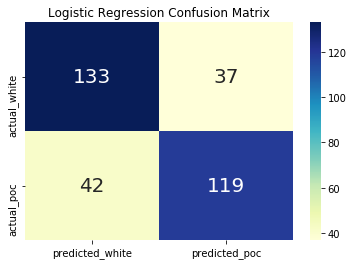

In [38]:
conf_matrix(y_val, y_pred_logit, 'Logistic Regression')

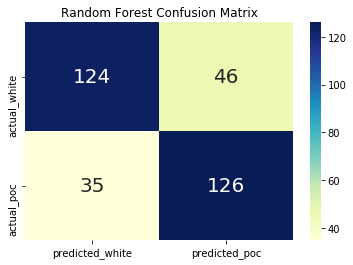

In [39]:
conf_matrix(y_val, y_pred_rf, 'Random Forest')

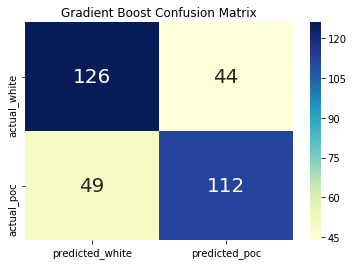

In [40]:
conf_matrix(y_val, y_pred_grad, 'Gradient Boost')

#### ROC Curve

In [41]:
logit_roc = roc_curve_generator(X_val, y_val, 'Logistic Regression', logit)
rf_roc = roc_curve_generator(X_val, y_val, 'Random Forest', rf)
grad_roc = roc_curve_generator(X_val, y_val, 'Gradient Boost', grad)

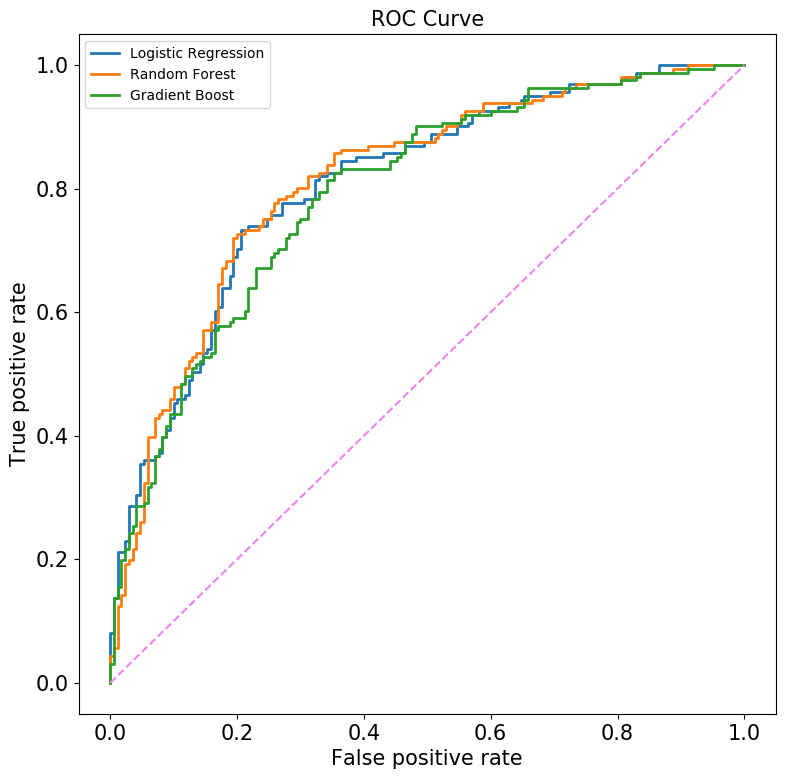

In [42]:
fig1 = plt.figure(figsize=[9,9], dpi=100)

plt.plot(logit_roc['Logistic Regression']['False Positive Rate'].values,    \
         logit_roc['Logistic Regression']['True Positive Rate'].values,    \
         lw=2, label='Logistic Regression')
plt.plot(rf_roc['Random Forest']['False Positive Rate'].values,    \
         rf_roc['Random Forest']['True Positive Rate'].values,    \
         lw=2, label='Random Forest')
plt.plot(grad_roc['Gradient Boost']['False Positive Rate'].values,    \
         grad_roc['Gradient Boost']['True Positive Rate'].values,    \
         lw=2, label='Gradient Boost')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve', fontsize=15);
plt.legend(fontsize=10)

#### Precision-Recall Curve

In [43]:
# logit_prec_rec = prec_rec_curve_generator(X_test, y_test, 'Logistic Regression', logit)

## GridSearch

In [44]:
def gridsearch(X_train, y_train, X_test, y_test, model, model_name, params, cv, score, error_score):
    
    gs = GridSearchCV(model, params, cv=cv, scoring=score, error_score=error_score)
    gs.fit(X_train, y_train)
    y_true, y_pred = y_test, gs.predict(X_test)
    
    print(model_name)
    print('-------------------------------------')
    print('Best Parameters are:', gs.best_params_)
    print('accuracy =', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred))
    print('recall = ', recall_score(y_true, y_pred))
    print('f1 score = ', f1_score(y_true, y_pred))
    

In [45]:
# Logistic Regression
logit_params = [
                {'max_iter': [1000000]},
#                 {'penalty': ['none', 'l2']},
                {'solver': ['liblinear']},
                {'C': [0.00001,0.0001,0.001,0.01,0.1,1]},
                {'random_state': [42]}
               ]

rf_params = [
             {'n_estimators': [10,100,1000]},
             {'max_depth': [2,6,10]},
             {'min_samples_leaf': [1,5,10]},
             {'max_leaf_nodes': [5,10]},
             {'random_state': [42]}
            ]



In [46]:
# gridsearch(X_tr, y_train, X_te, y_test, LogisticRegression(),
#            'Logistic Regression', logit_params, 5, 'f1', 0.0)

In [47]:
# gridsearch(X_tr, y_train, X_te, y_test, RandomForestClassifier(),
#            'Random Forest', rf_params, 5, 'f1', 0.0)

In [48]:
for c in [0.00001,0.0001,0.001,0.01,0.1,1,10]:
    
    gs_logit = LogisticRegression(C=c, solver = 'liblinear', random_state=42, max_iter = 10000)
    gs_logit.fit(X_smote_train, y_smote_train)
    y_true, y_pred = y_val, gs_logit.predict(X_val)

    print('C = ', c)
    print('accuracy =', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred))
    print('recall = ', recall_score(y_true, y_pred))
    print('f1 score = ', f1_score(y_true, y_pred))
    print('--------------------------------------')

C =  1e-05
accuracy = 0.7341389728096677
precision =  0.7354838709677419
recall =  0.7080745341614907
f1 score =  0.721518987341772
--------------------------------------
C =  0.0001
accuracy = 0.7552870090634441
precision =  0.7564102564102564
recall =  0.7329192546583851
f1 score =  0.7444794952681387
--------------------------------------
C =  0.001
accuracy = 0.7643504531722054
precision =  0.7677419354838709
recall =  0.7391304347826086
f1 score =  0.7531645569620251
--------------------------------------
C =  0.01
accuracy = 0.7613293051359517
precision =  0.7662337662337663
recall =  0.7329192546583851
f1 score =  0.7492063492063493
--------------------------------------
C =  0.1
accuracy = 0.7613293051359517
precision =  0.7628205128205128
recall =  0.7391304347826086
f1 score =  0.750788643533123
--------------------------------------
C =  1
accuracy = 0.7583081570996979
precision =  0.7579617834394905
recall =  0.7391304347826086
f1 score =  0.7484276729559748
---------------

## Coefficients

In [49]:
logit_final = LogisticRegression(C=0.001, solver = 'liblinear', random_state=42, max_iter = 10000)
logit_final.fit(X_smote_train, y_smote_train)
y_true, y_pred = y_val, logit_final.predict(X_val)

In [50]:
import math

beta_list = []

for array in logit_final.coef_:
    for i in array:
        odds = math.exp(i)
        probs = odds/(1+odds)
        beta_list.append(odds)
        
beta_coeffs_dict = {'Feature Name': model_killings_df.columns, 'Coefficient Value': beta_list}
beta_coeffs_df = pd.DataFrame(beta_coeffs_dict)
beta_coeffs_df = beta_coeffs_df.sort_values(by='Coefficient Value', ascending=True).reset_index(drop=True)
beta_coeffs_df

,Feature Name,Coefficient Value
0,age,0.959879
1,signs_of_mental_illness,0.967711
2,share_native_american,0.971529
3,share_white,0.987636
4,region_South,0.989599
5,poverty_rate,0.991678
6,armed,0.993805
7,threat_level,0.994390
8,month_May,0.994534
9,month_December,0.994940


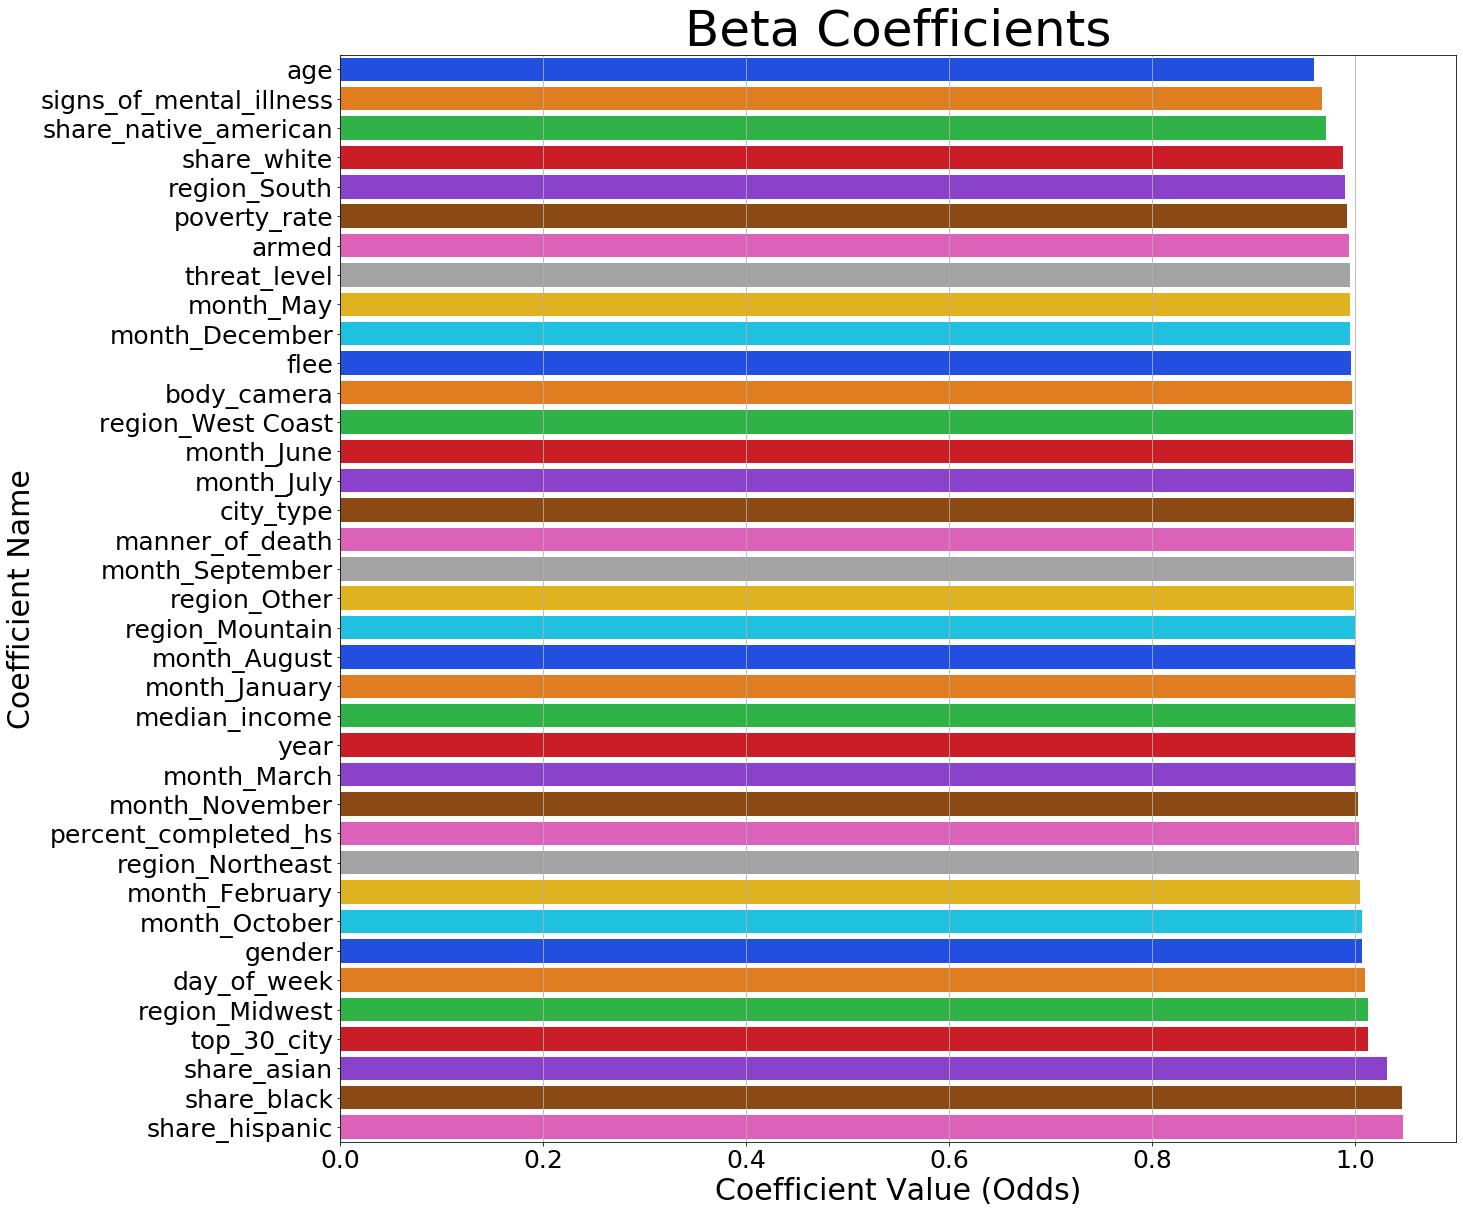

In [51]:
# Plot beta coefficients:

plt.figure(figsize=(20, 20))
plt.grid(axis='x', linestyle = '-')
sns.barplot(x = beta_coeffs_df['Coefficient Value'],y = beta_coeffs_df['Feature Name'], palette = "bright")
#             .set(xticklabels = ['-$10K', '-$5K', '$0', '$5K', '$10K', '$15K'], yticklabels = ['Concert in June', '# of Supporting Acts', 'Venue Capacity', 'Maximum Ticket Price', 'Minimum Ticket Price',  'Artist Genre: Indie Rock', 'Artist Genre: Electronic', 'Artist Genre: Pop', 'Artist Genre: Metal', 'Artist Genre: Jazz'])
plt.title('Beta Coefficients', fontsize = 50)
plt.xlabel('Coefficient Value (Odds)', fontsize = 30)
plt.ylabel('Coefficient Name', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
# for i in beta_coeffs:
#     bars.text(i.name,i.tip, round(i.total_bill,2), color='black', ha="center")
plt.show()